In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.system import System
from src.lobe.lcu import LCU
from colors import *
from cirq.contrib.svg import SVGCircuit
from openparticle import generate_matrix
from src.lobe._utils import get_basis_of_full_system
from src.lobe.bosonic import bosonic_mode_block_encoding, bosonic_mode_plus_hc_block_encoding
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from src.lobe._utils import get_bosonic_exponents
from functools import partial

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-14 14:49:42,108	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def qosc_Hamiltonian(g):
    return ParticleOperator('a0^ a0') + g * (
        ParticleOperator('a0^') + ParticleOperator('a0')
    )**4

In [4]:
def check_unitary(operator, circuit, max_bose_occ, system, rescaling_factor):
    if len(circuit.all_qubits()) < 12:
        print("Checking Unitary: ", max_bose_occ)
        full_fock_basis = get_basis_of_full_system(
            system.number_of_modes,
            max_bose_occ,
            has_fermions=operator.has_fermions,
            has_antifermions=operator.has_antifermions,
            has_bosons=operator.has_bosons,
        )
        expected_unitary = generate_matrix(operator, full_fock_basis)
        rescaled_block = circuit.unitary()[:1 << system.number_of_system_qubits, :1 << system.number_of_system_qubits]*rescaling_factor
        if not np.allclose(rescaled_block, expected_unitary):
            print(circuit)
            print(rescaled_block.real.round(2))
            print(expected_unitary.real.round(2))
            assert False
        print("Passed")
    else:
        print("Skipped: ", len(circuit.all_qubits()))
    

In [5]:
def qosc_lcu_circuit_metrics(max_bose_occ):
    operator = qosc_Hamiltonian(g = 1).normal_order()
    operator.remove_identity()

    lcu = LCU(operator, max_bose_occ=max_bose_occ, zero_threshold=1e-6)
    circuit = lcu.get_circuit()
    if len(circuit.all_qubits()) < 12:
        print("Checking Unitary: ", max_bose_occ)
        full_fock_basis = get_basis_of_full_system(
            1,
            max_bose_occ,
            has_fermions=operator.has_fermions,
            has_antifermions=operator.has_antifermions,
            has_bosons=operator.has_bosons,
        )
        expected_unitary = generate_matrix(operator, full_fock_basis)
        if not np.allclose(lcu.unitary, expected_unitary):
            print(circuit)
            print(lcu.unitary.real.round(2))
            print(expected_unitary.real.round(2))
            assert False
        print("Passed")
    else:
        print("Skipped: ", len(circuit.all_qubits()))
    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register)

In [6]:
def _be_second_term(system, block_encoding_ancillae, exponent, clean_ancillae=[], ctrls=([], [])):
    gates = []
    metrics = CircuitMetrics()
    for i in range(exponent):
        _gates, _metrics = bosonic_mode_plus_hc_block_encoding(
            system,
            [block_encoding_ancillae[2*i]]+[block_encoding_ancillae[(2*i)+1]],
            0,
            (1, 0),
            clean_ancillae=clean_ancillae[1:],
            ctrls=ctrls
        )
        gates += _gates
        metrics += _metrics
    return gates, metrics

def qosc_smart_lobe(max_bose_occ):
    coeffs = [1, 1]

    exponent = 4
    index_register = [cirq.LineQubit(-1)]
    block_encoding_ancillae = [cirq.LineQubit(-2 - i) for i in range((2*exponent)+1)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(1, max_bose_occ, 1000, False, False, True)

    block_encoding_functions = [
        partial(
            bosonic_mode_block_encoding,
            system=system,
            block_encoding_ancilla=block_encoding_ancillae[0],
            active_index=0,
            exponents=(1, 1),
            clean_ancillae=clean_ancillae[1:]
        ),
        partial(
            _be_second_term,
            system=system,
            block_encoding_ancillae=block_encoding_ancillae,
            exponent=exponent,
            clean_ancillae=clean_ancillae[1:]
        )
    ]
    rescaling_factors = [max_bose_occ, (2*(np.sqrt(max_bose_occ)))**exponent]

    rescaled_coefficients = []
    for coeff, rescaling_factor in zip(coeffs, rescaling_factors):
        rescaled_coefficients.append(coeff * rescaling_factor / max(rescaling_factors))

    target_state = get_target_state(rescaled_coefficients)
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    overall_rescaling_factor = sum([coeff*rescaling_factor for coeff, rescaling_factor in zip(coeffs, rescaling_factors)])
    circuit = cirq.Circuit(gates)
    check_unitary(qosc_Hamiltonian(1), circuit, max_bose_occ, system, overall_rescaling_factor)

    return  metrics, overall_rescaling_factor, len(block_encoding_ancillae) + 1, circuit

In [7]:
def qosc_lobe_circuit_metrics(max_bose_occ):
    operator = qosc_Hamiltonian(1).normal_order()
    operator.remove_identity()
    terms = operator.group()
    
    number_of_block_encoding_anillae = 2
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(terms)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_anillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(1, max_bose_occ, 1000, False, False, True)

    block_encoding_functions = []
    rescaling_factors = []
    for term in terms:
        plus_hc = False
        if len(term) == 2:
            plus_hc = True
            term = term.to_list()[0]
        active_modes, exponents_list = get_bosonic_exponents(term, 1)
        exponents = exponents_list[0]

        if not plus_hc:
            block_encoding_functions.append(partial(
                bosonic_mode_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae[1],
                active_index=active_modes[0],
                exponents=exponents,
                clean_ancillae=clean_ancillae[1:]
            ))
            rescaling_factors.append(np.sqrt(max_bose_occ)**(sum(exponents)))
        else:
            block_encoding_functions.append(partial(
                bosonic_mode_plus_hc_block_encoding,
                system=system,
                block_encoding_ancillae=block_encoding_ancillae,
                active_index=active_modes[0],
                exponents=exponents,
                clean_ancillae=clean_ancillae[1:]
            ))
            rescaling_factors.append(2*np.sqrt(max_bose_occ)**(sum(exponents)))



    rescaled_coefficients = []
    for term, rescaling_factor in zip(terms, rescaling_factors):
        rescaled_coefficients.append(term.coeffs[0] * rescaling_factor / max(rescaling_factors))

    target_state = get_target_state(rescaled_coefficients)
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    overall_rescaling_factor = sum([term.coeffs[0]*rescaling_factor for term, rescaling_factor in zip(terms, rescaling_factors)])
    circuit = cirq.Circuit(gates)
    check_unitary(operator, circuit, max_bose_occ, system, overall_rescaling_factor)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_anillae

In [8]:
omegas = [1, 3, 7, 15, 31]
print("LCU")
LCU_DATA = [qosc_lcu_circuit_metrics(omega) for omega in omegas]
print("LOBE")
LOBE_DATA = [qosc_lobe_circuit_metrics(omega) for omega in omegas]
print("Smart LOBE")
SMART_LOBE_DATA = [qosc_smart_lobe(omega) for omega in omegas]

system_qubits = [System(1, omega, 1000, False, False, True).number_of_system_qubits for omega in omegas]

LCU
Checking Unitary:  1
Passed
Checking Unitary:  3
Passed
Checking Unitary:  7
Passed
Checking Unitary:  15
Passed
Skipped:  13
LOBE
Checking Unitary:  1
Passed
Skipped:  12
Skipped:  14
Skipped:  16
Skipped:  18
Smart LOBE
Skipped:  15
Skipped:  17
Skipped:  19
Skipped:  21
Skipped:  23


In [9]:
def matrix_element(k, l, g):
    return (k + 3 * g * (2 * k ** 2 + 2 * k + 1)) * delta(k, l) +\
            g * (4 * l + 6) * np.sqrt((l + 1) * (l + 2)) * delta(k, l + 2) +\
            g * (4 * k + 6) * np.sqrt((k + 1) * (k + 2)) * delta(k + 2, l) +\
            g * np.sqrt((l + 1) * (l + 2) * (l + 3) * (l + 4)) * delta(k, l + 4) +\
            g * np.sqrt((k + 1) * (k + 2) * (k + 3) * (k + 4)) * delta(k + 4, l) 

def delta(k, l):
    if k == l: return 1 
    return 0


def _get_qosc_hamiltonian_norm(max_bose_occ, g=1):
    H_from_matrix_elements = np.zeros((max_bose_occ + 1, max_bose_occ + 1))

    for i in range(max_bose_occ + 1):
        for j in range(max_bose_occ + 1):
            H_from_matrix_elements[i][j] = matrix_element(i, j, g)

    vals = np.linalg.eigvalsh(H_from_matrix_elements)
    return max(np.abs(vals))

In [10]:
operator = qosc_Hamiltonian(1).normal_order()
operator.remove_identity()
operator_norms = []
for omega in omegas:
    operator_norms.append(_get_qosc_hamiltonian_norm(omega))
    print(omega, operator_norms[-1])

1 16.0
3 86.50949253027682
7 465.3766497208944
15 2372.168169309277
31 11342.80533747993


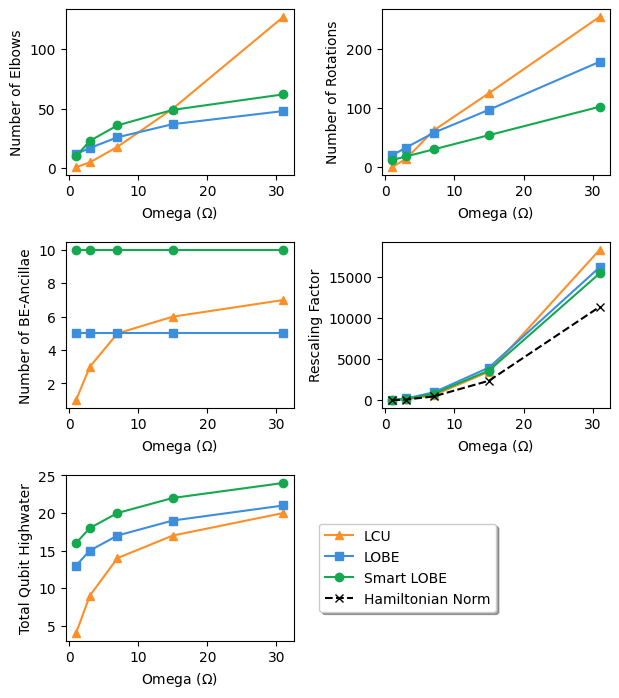

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(16 / 2.54, 18 / 2.54))

axes[0][0].plot(omegas, [LCU_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[0][0].plot(omegas, [LOBE_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1)
axes[0][0].plot(omegas, [SMART_LOBE_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=GREEN, marker='o', alpha = 1)
axes[0][0].set_ylabel("Number of Elbows")
axes[0][0].set_xlabel("Omega ($\Omega$)")

axes[0][1].plot(omegas, [LCU_DATA[i][0].number_of_rotations for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[0][1].plot(omegas, [LOBE_DATA[i][0].number_of_rotations for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1)
axes[0][1].plot(omegas, [SMART_LOBE_DATA[i][0].number_of_rotations for i in range(len(omegas))], color=GREEN, marker='o', alpha = 1)
axes[0][1].set_ylabel("Number of Rotations")
axes[0][1].set_xlabel("Omega ($\Omega$)")

axes[1][0].plot(omegas, [LCU_DATA[i][2] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[1][0].plot(omegas, [LOBE_DATA[i][2] for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1)
axes[1][0].plot(omegas, [SMART_LOBE_DATA[i][2] for i in range(len(omegas))], color=GREEN, marker='o', alpha = 1)
axes[1][0].set_ylabel("Number of BE-Ancillae")
axes[1][0].set_xlabel("Omega ($\Omega$)")

axes[1][1].plot(omegas, [LCU_DATA[i][1] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[1][1].plot(omegas, [LOBE_DATA[i][1] for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1)
axes[1][1].plot(omegas, [SMART_LOBE_DATA[i][1] for i in range(len(omegas))], color=GREEN, marker='o', alpha = 1)
axes[1][1].plot(omegas, [operator_norms[i] for i in range(len(omegas))], color="black", marker='x', ls='--', alpha = 1)
axes[1][1].set_ylabel("Rescaling Factor")
axes[1][1].set_xlabel("Omega ($\Omega$)")

axes[2][0].plot(omegas, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1, label="LCU")
axes[2][0].plot(omegas, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1, label="LOBE")
axes[2][0].plot(omegas, [SMART_LOBE_DATA[i][0].ancillae_highwater() + SMART_LOBE_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=GREEN, marker='o', alpha = 1, label="Smart LOBE")
axes[2][0].plot([], [], color="black", marker='x', ls='--', alpha = 1, label="Hamiltonian Norm")
axes[2][0].set_ylabel("Total Qubit Highwater")
axes[2][0].set_xlabel("Omega ($\Omega$)")

fig.delaxes(axes[2][1])
plt.tight_layout()
axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
          fancybox=True, shadow=True, ncol=1)
plt.savefig("../manuscript/figures/quartic_oscillator.pdf", dpi=300)